You can run this notebook in a [live session](https://binder.pangeo.io/v2/gh/pangeo-data/climpred/main?urlpath=lab/tree/docs/source/examples/subseasonal/weekly-subx-example.ipynb) [<img src="https://mybinder.org/badge_logo.svg" alt='binder badge'>](https://binder.pangeo.io/v2/gh/pangeo-data/climpred/main?urlpath=lab/tree/docs/source/examples/subseasonal/weekly-subx-example.ipynb) or view it [on Github](https://github.com/pangeo-data/climpred/blob/main/docs/source/examples/subseasonal/weekly-subx-example.ipynb).

## Calculate skill of a MJO Index of SubX model GEOS_V2p1 as function of weekly lead time

In this example, we demonstrate: 

1. How to remotely access data from the Subseasonal Experiment (SubX) hindcast database and set it up to be used in `climpred`. 
2. How to calculate the Anomaly Correlation Coefficient (ACC) using weekly data with `climpred`
3. How to calculate and plot historical forecast skill of the real-time multivariate MJO (RMM) indices as function of lead time.

### The Subseasonal Experiment (SubX)

Further information on SubX is available from [Pegion et al. 2019](https://journals.ametsoc.org/doi/full/10.1175/BAMS-D-18-0270.1) and the [SubX project website](http://cola.gmu.edu/subx/).

The SubX public database is hosted on the International Research Institute for Climate and Society (IRI) data server [http://iridl.ldeo.columbia.edu/SOURCES/.Models/.SubX/](http://iridl.ldeo.columbia.edu/SOURCES/.Models/.SubX/).

Since the SubX data server is accessed via this notebook, the time for the notebook to run may is several minutes and will vary depending on the speed that data can be downloaded. This is a large dataset, so please be patient. If you prefer to download SubX data locally, scripts are available from [https://github.com/kpegion/SubX](https://github.com/kpegion/SubX).

### Definitions

**RMM**
: Two indices (RMM1 and RMM2) are used to represent the MJO. Together they define the MJO based on 8 phases and can represent both the phase and amplitude of the MJO {cite:p}`Wheeler2004`. This example uses the observed RMM1 provided by Matthew Wheeler at the Center for Australian Weather and Climate Research. It is the version of the indices in which interannual variability has not been removed.

**Skill of RMM**
: Traditionally, the skill of the RMM is calculated as a bivariate correlation encompassing the skill of the two indices together {cite:p}`Rashid2011,Gottschalck2010`.  Currently, `climpred` does not have the functionality to calculate the bivariate correlation, thus the anomaly correlation coefficient for RMM1 index is calculated here as a demonstration.  The bivariate correlation metric will be added in a future version of `climpred`.

In [1]:
# linting
%load_ext nb_black
%load_ext lab_black

<IPython.core.display.Javascript object>

In [2]:
import warnings

import matplotlib.pyplot as plt

import xarray as xr
import pandas as pd
import numpy as np

from climpred import HindcastEnsemble
import climpred

warnings.filterwarnings("ignore")

<IPython.core.display.Javascript object>

Read the observed RMM Indices

In [3]:
obsds = climpred.tutorial.load_dataset("RMM-INTERANN-OBS")[["rmm1"]]
obsds

<xarray.Dataset>
Dimensions:  (time: 15613)
Coordinates:
  * time     (time) datetime64[ns] 1974-06-03 1974-06-04 ... 2017-07-24
Data variables:
    rmm1     (time) float64 ...

<IPython.core.display.Javascript object>

Read the SubX RMM1 data for the GMAO-GEOS_V2p1 model from the SubX data server.  It is important to note that the SubX data contains weekly initialized forecasts where the `init` day varies by model.  SubX data may have all NaNs for initial dates in which a model does not make a forecast, thus we apply `dropna` over the `S=init` dimension when `how=all` data for a given `S=init` is missing.  This can be slow, but allows the rest of the calculations to go more quickly. 

Note that we ran the `dropna` operation offline and then uploaded the post-processed SubX dataset to the `climpred-data` repo for the purposes of this demo. This is how you can do this manually:

```python
url = 'http://iridl.ldeo.columbia.edu/SOURCES/.Models/.SubX/.GMAO/.GEOS_V2p1/.hindcast/.RMM/.RMM1/dods/'
fcstds = xr.open_dataset(url, decode_times=False, chunks={'S': 1, 'L': 45}).dropna(dim='S',how='all')
```

In [4]:
fcstds = climpred.tutorial.load_dataset("GMAO-GEOS-RMM1", decode_times=False)
fcstds

<xarray.Dataset>
Dimensions:  (S: 510, M: 4, L: 45)
Coordinates:
  * S        (S) float32 1.424e+04 1.425e+04 1.426e+04 ... 2.044e+04 2.045e+04
  * M        (M) float32 1.0 2.0 3.0 4.0
  * L        (L) float32 0.5 1.5 2.5 3.5 4.5 5.5 ... 40.5 41.5 42.5 43.5 44.5
Data variables:
    RMM1     (S, M, L) float32 ...
Attributes:
    Conventions:  IRIDL

<IPython.core.display.Javascript object>

The SubX data dimensions correspond to the following `climpred` dimension definitions: `X=lon`,`L=lead`,`Y=lat`,`M=member`, `S=init`.  We will rename the dimensions to their `climpred` names.

In [5]:
fcstds = fcstds.rename({"S": "init", "L": "lead", "M": "member", "RMM1": "rmm1"})

<IPython.core.display.Javascript object>

Let's make sure that the `lead` dimension is set properly for `climpred`.  SubX data stores `leads` as 0.5, 1.5, 2.5, etc, which correspond to 0, 1, 2, ... days since initialization. We will change the `lead` to be integers starting with zero. 

In [6]:
fcstds["lead"] = (fcstds["lead"] - 0.5).astype("int")

<IPython.core.display.Javascript object>

Now we need to make sure that the `init` dimension is set properly for `climpred`. We use an `xarray` convenience function to decode it into the proper CFTime calendar. It can detect that this is on a 360 day calendar.

In [7]:
fcstds = xr.decode_cf(fcstds, decode_times=True)

<IPython.core.display.Javascript object>

Make Weekly/7-day Averages

In [8]:
fcstweekly = fcstds.rolling(lead=7, center=False).mean().dropna(dim="lead")
obsweekly = obsds.rolling(time=7, center=False).mean().dropna(dim="time")
print(fcstweekly)
print()
print(obsweekly)

<xarray.Dataset>
Dimensions:  (init: 510, member: 4, lead: 39)
Coordinates:
  * init     (init) datetime64[ns] 1999-01-01 1999-01-06 ... 2015-12-27
  * member   (member) float32 1.0 2.0 3.0 4.0
  * lead     (lead) int64 6 7 8 9 10 11 12 13 14 ... 36 37 38 39 40 41 42 43 44
Data variables:
    rmm1     (init, member, lead) float32 0.1347 0.1095 ... 0.1404 0.07606
Attributes:
    Conventions:  IRIDL

<xarray.Dataset>
Dimensions:  (time: 15456)
Coordinates:
  * time     (time) datetime64[ns] 1974-06-09 1974-06-10 ... 2017-07-24
Data variables:
    rmm1     (time) float64 1.336 1.107 0.9046 0.695 ... 0.6265 0.673 0.7352


<IPython.core.display.Javascript object>

In [9]:
fcstweekly = fcstweekly.isel(lead=slice(None, None, 7)).assign_coords(
    lead=np.arange(1, 1 + fcstweekly.lead.size // 7 + 1)
)

<IPython.core.display.Javascript object>

`climpred` requires that `lead` dimension has an attribute called `units` indicating what time units the `lead` is assocated with.  Options are: `years`, `seasons`, `months`, `weeks`, `pentads`, `days`, `hours`, `minutes` or `seconds`.  The `lead` `units` are `weeks`. 

In [10]:
fcstweekly["lead"].attrs = {"units": "weeks"}

<IPython.core.display.Javascript object>

Create the {py:class}`.HindcastEnsemble` object and {py:meth}`.HindcastEnsemble.add_observations`.

In [11]:
hindcast = HindcastEnsemble(fcstweekly)
hindcast = hindcast.add_observations(obsweekly)
hindcast

climpred.HindcastEnsemble

<Initialized Ensemble>
Dimensions: (init: 510, member: 4, lead: 6)
Coordinates:
 * init (init) object 1999-01-01 00:00:00 ... 2015-12-27 00:00:00
 * member (member) float32 1.0 2.0 3.0 4.0
 * lead (lead) int64 1 2 3 4 5 6
 valid_time (lead, init) object 1999-01-08 00:00:00 ... 2016-02-07 00:00:00
Data variables:
 rmm1 (init, member, lead) float32 0.1347 -0.7031 ... 0.2992 0.4478
Attributes:
 Conventions: IRIDL Initialized Ensemble Dimensions: init : 510 member : 4 lead : 6 Coordinates: (4) init (init) object 1999-01-01 00:00:00 ... 2015-12-... standard_name : forecast_reference_time long_name : Initialization description : The forecast reference time in NWP is the "data time", the time of the analysis from which the forecast was made. It is not the time for which the forecast is valid; the standard name of time should be used for that time. array([cftime.DatetimeProlepticGregorian(1999, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1999, 1, 6, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1999, 1, 11, 0, 0, 0, 0, has_year_zero=True),
 ...,
 cftime.DatetimeProlepticGregorian(2015, 12, 17, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(2015, 12, 22, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(2015, 12, 27, 0, 0, 0, 0, has_year_zero=True)],
 dtype=object) member (member) float32 1.0 2.0 3.0 4.0 long_name : Member standard_name : realization pointwidth : 1.0 gridtype : 0 units : ids description : Realization is used to label a dimension that can be thought of as a statistical sample, e.g., labelling members of a model ensemble. array([1., 2., 3., 4.], dtype=float32) lead (lead) int64 1 2 3 4 5 6 units : weeks standard_name : forecast_period long_name : Lead description : Forecast period is the time interval between the forecast reference time and the validity time. A period is an interval of time, or the time-period of an oscillation. array([1, 2, 3, 4, 5, 6]) valid_time (lead, init) object 1999-01-08 00:00:00 ... 2016-02-... long_name : validity time standard_name : time description : time for which the forecast is valid calculate : init + lead amip : time array([[cftime.DatetimeProlepticGregorian(1999, 1, 8, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1999, 1, 13, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1999, 1, 18, 0, 0, 0, 0, has_year_zero=True),
 ...,
 cftime.DatetimeProlepticGregorian(2015, 12, 24, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(2015, 12, 29, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(2016, 1, 3, 0, 0, 0, 0, has_year_zero=True)],
 [cftime.DatetimeProlepticGregorian(1999, 1, 15, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1999, 1, 20, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1999, 1, 25, 0, 0, 0, 0, has_year_zero=True),
 ...,
 cftime.DatetimeProlepticGregorian(2015, 12, 31, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(2016, 1, 5, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(2016, 1, 10, 0, 0, 0, 0, has_year_zero=True)],
 [cftime.DatetimeProlepticGregorian(1999, 1, 22, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1999, 1, 27, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1999, 2, 1, 0, 0, 0, 0, has_year_zero=True),
 ...,
 cftime.DatetimeProlepticGregorian(2016, 1, 7, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(2016, 1, 12, 0, 0, 0, 0, has_year_zero=True),
...
 cftime.DatetimeProlepticGregorian(1999, 2, 8, 0, 0, 0, 0, has_year_zero=True),
 ...,
 cftime.DatetimeProlepticGregorian(2016, 1, 14, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(2016, 1, 19, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(2016, 1, 24, 0, 0, 0, 0, has_year_zero=True)],
 [cftime.DatetimeProlepticGregorian(1999, 2, 5, 0, 0, 0, 0, has_year_zero=Tru

<Observations>
Dimensions: (time: 15456)
Coordinates:
 * time (time) object 1974-06-09 00:00:00 ... 2017-07-24 00:00:00
Data variables:
 rmm1 (time) float64 1.336 1.107 0.9046 0.695 ... 0.6265 0.673 0.7352 Observations Dimensions: time : 15456 Coordinates: (1) time (time) object 1974-06-09 00:00:00 ... 2017-07-... long_name : time standard_name : time array([cftime.DatetimeProlepticGregorian(1974, 6, 9, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1974, 6, 10, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1974, 6, 11, 0, 0, 0, 0, has_year_zero=True),
 ...,
 cftime.DatetimeProlepticGregorian(2017, 7, 22, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(2017, 7, 23, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(2017, 7, 24, 0, 0, 0, 0, has_year_zero=True)],
 dtype=object) Data variables: (1) rmm1 (time) float64 1.336 1.107 0.9046 ... 0.673 0.7352 array([1.33585898, 1.10670328, 0.90462442, ..., 0.62653254, 0.6730053 ,
 0.73522198]) Attributes: (0)

<IPython.core.display.Javascript object>

Calculate the Anomaly Correlation Coefficient (ACC) {py:func}`.climpred.metrics._pearson_r`.

In [12]:
skill = hindcast.verify(
    metric="acc", comparison="e2o", alignment="maximize", dim="init"
)
skill

<xarray.Dataset>
Dimensions:  (lead: 6)
Coordinates:
  * lead     (lead) int64 1 2 3 4 5 6
    skill    <U11 'initialized'
Data variables:
    rmm1     (lead) float64 0.948 0.8719 0.7265 0.5658 0.4504 0.3607
Attributes:
    Conventions:                   IRIDL
    prediction_skill_software:     climpred https://climpred.readthedocs.io/
    skill_calculated_by_function:  HindcastEnsemble.verify()
    number_of_initializations:     510
    number_of_members:             4
    alignment:                     maximize
    metric:                        pearson_r
    comparison:                    e2o
    dim:                           init
    reference:                     []

<IPython.core.display.Javascript object>

Plot the skill as a function of lead time

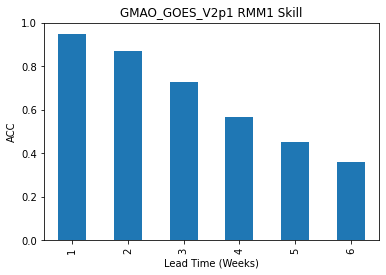

<IPython.core.display.Javascript object>

In [13]:
skill.rmm1.to_series().plot(kind="bar")
plt.title("GMAO_GOES_V2p1 RMM1 Skill")
plt.xlabel("Lead Time (Weeks)")
plt.ylabel("ACC")
plt.ylim(0.0, 1.0)
plt.show()

### References

```{eval-rst}
.. bibliography::
   :filter: docname in docnames
```